# Electron Photon tagging

This is a test to see if an isolation forest on the latent space of an autoencoder trained on photons improves the anomaly tagging performance


### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses
import h5py
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

2022-07-29 16:44:25.880277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 16:44:25.880295: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-29 16:44:26.926124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 16:44:26.926148: W tensorflow/

## data

In [2]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

In [3]:
electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

In [4]:
x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [5]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [6]:
x_train = x_train.reshape(x_train.shape + (1,))
x_train_electrons = x_train_electrons.reshape(x_train_electrons.shape + (1,))

x_val = x_val.reshape(x_val.shape + (1,))
x_val_electrons = x_val_electrons.reshape(x_val_electrons.shape + (1,))

x_test = x_test.reshape(x_test.shape + (1,))
x_test_electrons = x_test_electrons.reshape(x_test_electrons.shape + (1,))

In [7]:
max_norm = np.max(x_train)
x_train = x_train / max_norm
x_train_electrons = x_train_electrons / max_norm

x_val = x_val / max_norm
x_val_electrons = x_val_electrons / max_norm

x_test = x_test / max_norm
x_test_electrons = x_test_electrons / max_norm

## model

In [8]:
ae = cae.Convolutional_Autoencoder_gamma_e(128)

In [9]:
ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0005))#0.0005

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.000012)
hist = ae.fit(x_train,x_train,
                epochs=50,
                shuffle=True,
                batch_size=200,
                validation_data=(x_val,x_val),
                callbacks=[es])

Epoch 1/50
598/598 [==============================] - 97s 161ms/step - loss: 0.0251 - val_loss: 0.0026
Epoch 2/50
598/598 [==============================] - 99s 165ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/50
598/598 [==============================] - 111s 185ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/50
598/598 [==============================] - 105s 175ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/50
598/598 [==============================] - 103s 172ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/50
598/598 [==============================] - 106s 177ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/50
598/598 [==============================] - 102s 171ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/50
598/598 [==============================] - 103s 171ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/50
598/598 [==============================] - 106s 177ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/50
598/598 [==============================] - 103s 173ms/

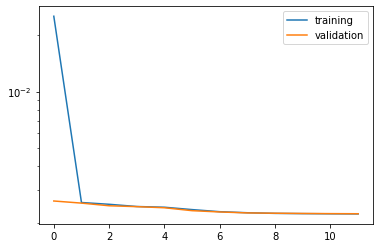

In [11]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

## "classical" evalutation by comparing reconstruction loss

In [12]:
from hep_VQAE import utils as ut

Collapse_metric: 0.919
Average EMD: 0.413
ssim: 0.996
MAE: 0.000177
normalized MAE: 0.00021


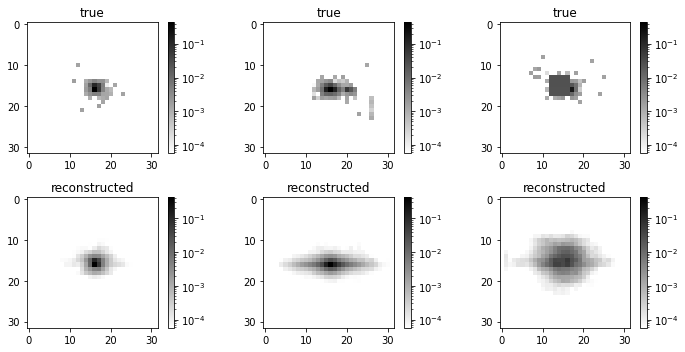

In [13]:
recon = ae.predict(x_test[:1000])

ut.eval_recon(x_test[:1000], recon, lognorm=True)

Median background: 0.00208
Median signal: 0.00229
Maximum accuracy: 0.592
AUC: 0.602


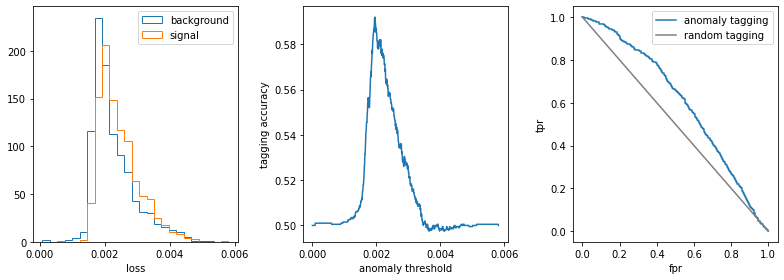

In [14]:
recon = ae.predict(x_test[:1000])
recon_e = ae.predict(x_test_electrons[:1000])

ut.eval_tagging(x_test[:1000], recon, x_test_electrons[:1000], recon_e)

## isolation forest on latent space evaluation

well seems to work not that well...

Median background: 0.0899
Median signal: 0.0856
Maximum accuracy: 0.527
AUC: 0.518


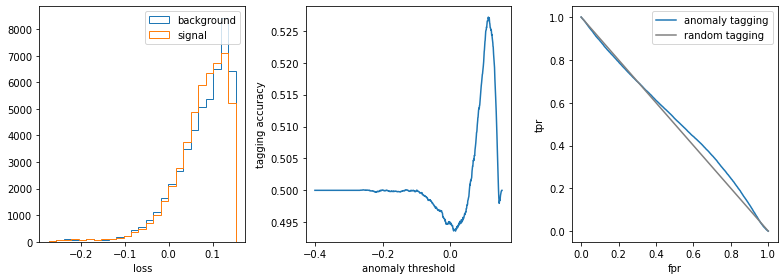

In [15]:
latent_test = ae.encoder(x_test[:50000])
latent_test_e = ae.encoder(x_test_electrons[:50000])

from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0).fit(latent_test)

if_pred_test = clf.decision_function(latent_test)
if_pred_test_e = clf.decision_function(latent_test_e)

ut.iforest_latent_eval(latent_test, latent_test_e)